# Made with ML

- https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb
- https://madewithml.com/

# 4. Develop
## 4.1 Scripting

### Intuition

이 단원에서는 노트북에서 Python 스크립트로 코드를 마이그레이션하고 정리하는 방법에 대해 설명합니다.   
이 강좌에서는 VSCode를 사용하지만, 편한 편집기를 자유롭게 사용하셔도 됩니다.

지금까지 노트북은 개발에 매우 유용했습니다.  
대화형이고, 상태 저장(코드를 다시 실행할 필요가 없음)이 가능하며, 출력을 시각화할 수 있기 때문입니다.  
하지만 고품질의 코드베이스를 개발하려면 스크립트로 전환해야 합니다.  
그 이유는 다음과 같습니다:

- stateless: 노트북에서 코드를 실행하면 자동으로 전역 상태(메모리)에 저장됩니다.  
이는 여러 셀에서 코드와 변수를 쉽게 사용할 수 있기 때문에 실험에 유용합니다.  
하지만 우리가 인지하지 못하는 숨겨진 상태가 있을 수 있기 때문에 문제가 될 수 있습니다.  
반면에 스크립트는 상태가 없으며 함수와 클래스에 변수를 명시적으로 전달해야 합니다.

- linear: 노트북에서는 셀을 실행하는 순서가 중요합니다. 셀을 순서 없이 실행하기 쉽기 때문에 문제가 될 수 있습니다.   반면에 스크립트는 선형적이며 각 워크로드에 대해 명시적으로 코드를 실행해야 합니다.

- 테스트: 테스트 강의에서 살펴보겠지만, Jupyter 노트북과 달리 스크립트에서는 테스트를 작성하고 실행하는 것이 훨씬 더 쉽습니다. 이는 예상대로 작동하는 양질의 코드를 확보하는 데 매우 중요합니다.  

### Setup

### README

### Scripts

코드를 노트북에서 스크립트로 옮기는 것부터 시작하겠습니다.   
프로젝트에 필요한 다양한 파일과 디렉터리를 만드는 것부터 시작하겠습니다.  
이러한 스크립트의 정확한 수와 이름은 전적으로 저희에게 달려 있지만,  
특정 워크로드와 관련된 이름을 정리하고 선택하는 것이 가장 좋습니다.  
예를 들어, data.py에는 모든 데이터 관련 함수와 클래스가 포함됩니다.  
또한 구성(config.py), 공유 유틸리티(utils.py) 등을 위한 스크립트도 있을 수 있습니다.

```
madewithml/
├── config.py
├── data.py
├── evaluate.py
├── models.py
├── predict.py
├── serve.py
├── train.py
├── tune.py
└── utils.py
```

### Ray

설정 단원에서 노트북 내부에서 Ray를 초기화했던 것을 기억하시죠.   
스크립트를 통해 ML 워크로드를 실행하기 전에 여전히 Ray를 초기화해야 하지만,  
Ray 종속 워크로드가 있는 스크립트에 대해서만 이 작업을 수행하도록 결정할 수 있습니다.   
예를 들어, train.py 스크립트의 맨 아래에 있습니다:

```python
# madewithml/train.py
if __name__ == "__main__":
    if ray.is_initialized():
        ray.shutdown()
    ray.init()
    app()  # initialize Typer app
```

## 4.2 Command-Line Interface

### Intuition

이전 단원에서는 노트북의 코드를 개별 Python 스크립트로 정리했습니다.  
함수와 클래스를 각각의 스크립트로 옮기고 주요 ML 워크로드를 실행하기 위한 새로운 워크로드 함수도 만들었습니다  
(예: madewithml/train.py 스크립트의 train_model 함수).  
이제 사용자가 코드 자체에 대한 지식 없이도 터미널에서 이러한 워크로드를 실행할 수 있도록 하려고 합니다.

### Methods

이러한 워크로드를 실행하는 한 가지 방법은 Python 스크립트에서 함수를 가져와서 한 번에 하나씩 실행하는 것입니다:

```python
from madewithml import train
train.train_model(experiment_name="llm", ...)

```

Caution: Don't forget to run export PYTHONPATH=$PYTHONPATH:$PWD in your terminal to ensure that Python can find the modules in our project.

이 방법은 간단해 보이지만 패키지를 가져오고 입력 인수를 식별하는 등의 작업이 필요합니다.   
따라서 또 다른 대안은 스크립트를 직접 실행할 때만 실행되도록 메인 함수 호출을 if __name__ == "__main__" 조건문 아래에 배치하는 것입니다.  
여기서 입력 인수를 코드의 함수에 직접 전달할 수 있습니다.

```python
# madewithml/train.py
if __name__ == "__main__":
    train_model(experiment_name="llm", ...)
```

그리고 나서 터미널에서 다음과 같이 실행한다.   

```
python madewithml/train.py
```

하지만 여기서는 특정 스크립트에서 실행할 함수를 선택할 수 없다는 한계가 있습니다. if __name__ == "__main__" 조건 아래에서 실행할 함수를 설정해야 합니다. 또한 argparse와 같은 라이브러리를 사용하지 않는 한 코드에서 입력 인자 값을 설정해야 하므로 매우 엄격합니다.

```python
# madewithml/serve.py
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--run_id", help="run ID to use for serving.")
    parser.add_argument("--threshold", type=float, default=0.9, help="threshold for `other` class.")
    args = parser.parse_args()
    ray.init()
    serve.run(ModelDeployment.bind(run_id=args.run_id, threshold=args.threshold))
```

터미널에서 다음과 같이 호출할 수 있습니다(--threshold는 기본값이 있으므로 선택 사항입니다):   

```
python madewithml/serve.py --run_id $RUN_ID

```

madewithml/serve.py 스크립트에서 argparse를 사용하는 이유는 스크립트에서 유일한 워크로드이고 한 줄 함수 호출(serve.run())이기 때문입니다.

함수나 __main__ 조건을 사용하는 것과 비교했을 때 터미널에서 이러한 워크로드를 실행하는 것이 훨씬 더 나은 사용자 경험을 제공합니다. 이 단원에서는 주요 ML 워크로드를 실행할 수 있도록 명령줄 인터페이스(CLI)를 구축하는 방법을 알아보겠습니다.

### Typer

Typer를 사용하여 CLI를 만들겠습니다.  
앱을 초기화한 다음 스크립트에서 CLI 명령으로 사용하려는 각 함수 작업에 적절한 데코레이터를 추가하기만 하면 됩니다:

```python
import typer
from typing_extensions import Annotated
app = typer.Typer()

@app.command()
def train_model(
    experiment_name: Annotated[str, typer.Option(help="name of the experiment.")] = None,
    ...):
    pass

if __name__ == "__main__":
    app()
```

Inputs

함수 입력에는 input name 외에도 많은 정보가 있다는 것을 알 수 있습니다.  
tyyping(str, List 등)에 대해서는 문서화 강의에서 다루겠지만, 지금은 Annotated를 사용하면 입력 인자의 유형에 대한 메타데이터와 (필수) 옵션(typer.Option)에 대한 세부 정보를 지정할 수 있다는 점만 알아두세요.  


모든 입력 인수를 선택 사항으로 설정하여 CLI 명령(예: --experiment-name)에서 명시적으로 정의할 수 있도록 했습니다.


또한 입력 매개변수에 대한 유용한 정보를 추가할 수도 있습니다(typer.Option(help="...") 사용) 및 기본값(예: 없음)을 추가할 수도 있습니다.

userge

CLI 명령어를 정의하고 입력 인수를 보강하면 워크로드를 실행할 수 있습니다. 필요한 입력 매개변수가 무엇인지 모른다고 가정하고 train_model 함수를 실행해 보겠습니다. 코드를 살펴볼 필요 없이 다음과 같이 하면 됩니다:

```
python madewithml/train.py --help
```

```
Usage: train.py [OPTIONS]
Main train function to train our model as a distributed workload.
```

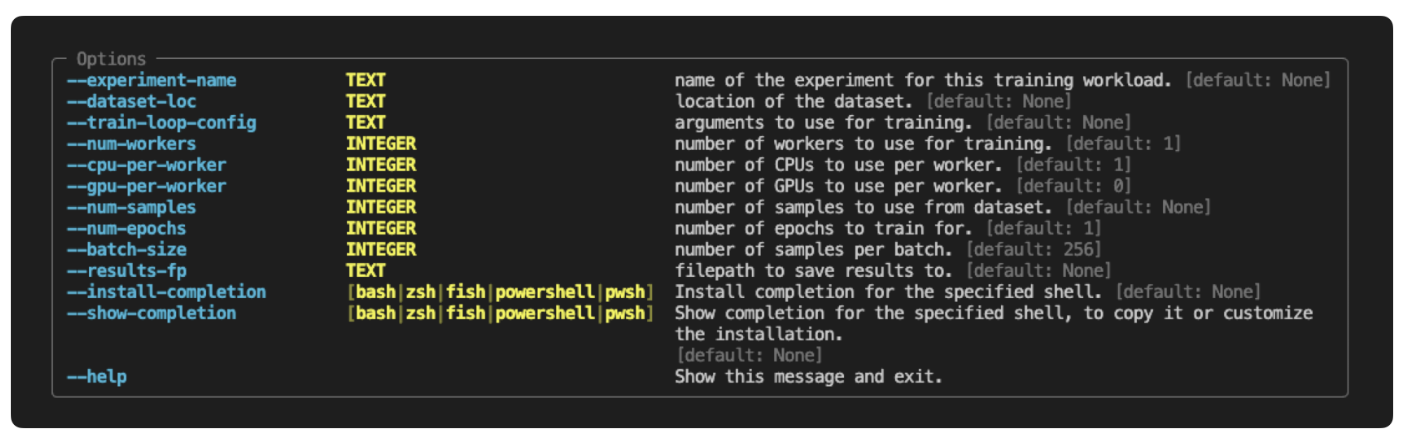